In [41]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import resample
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import GridSearchCV


In [42]:
df = pd.read_csv('sentimentdataset.csv')

# Ensure dataset has 'text' and 'sentiment' columns
if 'Text' not in df.columns or 'Sentiment' not in df.columns:
    raise ValueError("Dataset must contain 'text' and 'sentiment' columns.")

In [43]:
df.head()

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


In [44]:
print(df['Sentiment'].unique())

[' Positive  ' ' Negative  ' ' Neutral   ' ' Anger        '
 ' Fear         ' ' Sadness      ' ' Disgust      ' ' Happiness    '
 ' Joy          ' ' Love         ' ' Amusement    ' ' Enjoyment    '
 ' Admiration   ' ' Affection    ' ' Awe          ' ' Disappointed '
 ' Surprise     ' ' Acceptance   ' ' Adoration    ' ' Anticipation '
 ' Bitter       ' ' Calmness     ' ' Confusion    ' ' Excitement   '
 ' Kind         ' ' Pride        ' ' Shame        ' ' Confusion '
 ' Excitement ' ' Shame ' ' Elation       ' ' Euphoria      '
 ' Contentment   ' ' Serenity      ' ' Gratitude     ' ' Hope          '
 ' Empowerment   ' ' Compassion    ' ' Tenderness    ' ' Arousal       '
 ' Enthusiasm    ' ' Fulfillment  ' ' Reverence     ' ' Compassion'
 ' Fulfillment   ' ' Reverence ' ' Elation   ' ' Despair         '
 ' Grief           ' ' Loneliness      ' ' Jealousy        '
 ' Resentment      ' ' Frustration     ' ' Boredom         '
 ' Anxiety         ' ' Intimidation    ' ' Helplessness    '
 ' 

In [45]:

# Simplify Sentiment Labels
def map_to_general_sentiment(label):
    label = label.strip().lower()
    if label in [   'positive', 'happiness', 'joy', 'love', 'admiration', 'gratitude', 'hope', 'confidence', 
    'euphoria', 'success', 'excitement', 'pride', 'enthusiasm', 'kindness', 'positivity', 
    'triumph', 'satisfaction', 'serenity', 'inspiration', 'wonder', 'friendship', 'charm']:
        return 'positive'
    elif label in ['negative', 'anger', 'fear', 'sadness', 'disgust', 'grief', 'heartbreak', 'loneliness', 
    'betrayal', 'resentment', 'regret', 'frustration', 'anxiety', 'intimidation', 'sorrow', 
    'despair', 'helplessness', 'jealousy', 'bitterness', 'melancholy', 'hate', 'bad']:
        return 'negative'
    else:
        return 'neutral'

# Apply mapping
df['Sentiment'] = df['Sentiment'].apply(map_to_general_sentiment)

df['Sentiment'] = df['Sentiment'].apply(map_to_general_sentiment)

In [46]:
print(df['Sentiment'].unique())

['positive' 'negative' 'neutral']


In [47]:
print(df['Sentiment'].value_counts())

Sentiment
neutral     415
positive    216
negative    101
Name: count, dtype: int64


In [48]:
def preprocess_text(text):
    text = re.sub(r'http\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    text = text.lower().strip()  # Lowercase and strip whitespace
    return text

df['cleaned_text'] = df['Text'].apply(preprocess_text)


In [49]:
# Lemmatization
lemmatizer = WordNetLemmatizer()
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))


In [50]:
# Handle class imbalance
majority_class = df[df['Sentiment'] == df['Sentiment'].mode()[0]]
minority_classes = [df[df['Sentiment'] == cls] for cls in df['Sentiment'].unique() if cls != df['Sentiment'].mode()[0]]


In [51]:
resampled_minority_classes = [resample(cls, replace=True, n_samples=len(majority_class), random_state=42) for cls in minority_classes]
df_balanced = pd.concat([majority_class] + resampled_minority_classes)

Sentiment
neutral     415
positive    216
negative    101
Name: count, dtype: int64


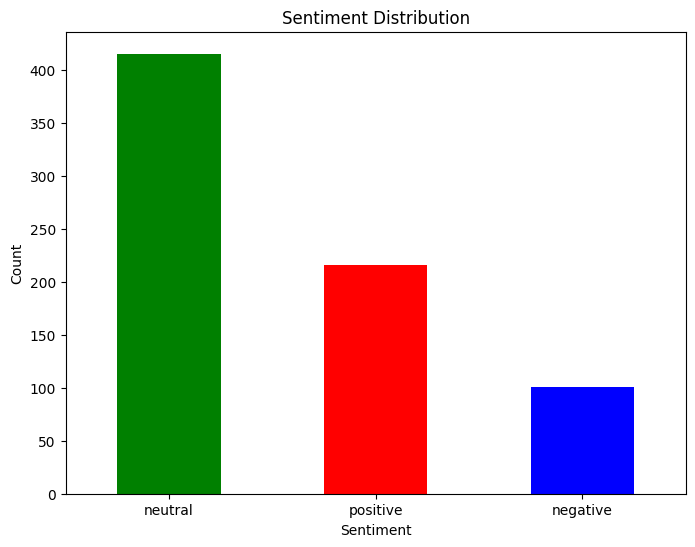

In [52]:
print(df['Sentiment'].value_counts())

# Plot the sentiment distribution
df['Sentiment'].value_counts().plot(kind='bar', color=['green', 'red', 'blue'], figsize=(8, 6))
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

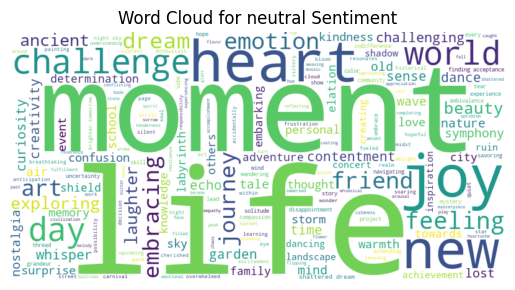

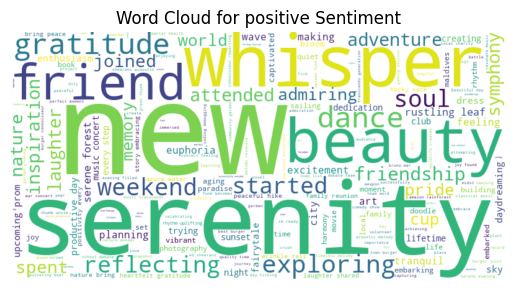

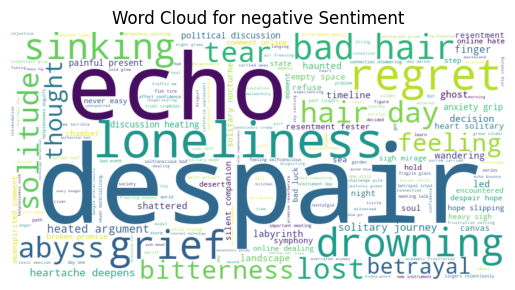

In [53]:
for sentiment in df_balanced['Sentiment'].unique():
    sentiment_text = ' '.join(df_balanced[df_balanced['Sentiment'] == sentiment]['cleaned_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(sentiment_text)
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {sentiment} Sentiment')
    plt.show()

In [54]:
# Step 4: Feature Extraction and Model Training
X = df_balanced['cleaned_text']
y = df_balanced['Sentiment']

In [65]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [66]:
vectorizers = {
    'BoW': CountVectorizer(ngram_range=(1, 2)),
    'TF-IDF': TfidfVectorizer(ngram_range=(1, 2))
}

In [67]:

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier()
}

In [68]:


for vec_name, vectorizer in vectorizers.items():
    print(f"\nUsing {vec_name} features:")
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    # Dimensionality reduction
    svd = TruncatedSVD(n_components=100, random_state=42)
    X_train_vec = svd.fit_transform(X_train_vec)
    X_test_vec = svd.transform(X_test_vec)

    for model_name, model in models.items():
        # Hyperparameter tuning for Logistic Regression
        if model_name == 'Logistic Regression':
            params = {'C': [0.01, 0.1, 1, 10]}
            grid = GridSearchCV(model, params, cv=5)
            grid.fit(X_train_vec, y_train)
            model = grid.best_estimator_

        model.fit(X_train_vec, y_train)
        y_pred = model.predict(X_test_vec)

        print(f"\nModel: {model_name}")
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
        print(classification_report(y_test, y_pred))
        


Using BoW features:

Model: Logistic Regression
Accuracy: 0.82
              precision    recall  f1-score   support

    negative       0.94      0.94      0.94        80
     neutral       0.76      0.74      0.75        92
    positive       0.76      0.79      0.78        77

    accuracy                           0.82       249
   macro avg       0.82      0.82      0.82       249
weighted avg       0.82      0.82      0.82       249


Model: SVM
Accuracy: 0.85
              precision    recall  f1-score   support

    negative       1.00      0.85      0.92        80
     neutral       0.74      0.95      0.83        92
    positive       0.89      0.74      0.81        77

    accuracy                           0.85       249
   macro avg       0.88      0.85      0.85       249
weighted avg       0.87      0.85      0.85       249


Model: KNN
Accuracy: 0.80
              precision    recall  f1-score   support

    negative       0.93      0.86      0.90        80
     neutra

In [74]:
import pickle

best_model = LogisticRegression(max_iter=1000)
best_model.fit(X_train_vec, y_train)

with open('best_vectorizer.pkl', 'wb') as vec_file, open('best_model.pkl', 'wb') as model_file:
    pickle.dump(vectorizer, vec_file)
    pickle.dump(best_model, model_file)

In [80]:
# Example new data
new_texts = [
    "I absolutely love this product! It works perfectly.",
    "Terrible experience. I won't recommend this to anyone.",
    "It's okay, nothing special to mention.",
  
]

# Preprocessing function (reuse the one defined earlier)
def preprocess_text(text):
    text = re.sub(r'http\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    text = text.lower().strip()  # Lowercase and strip whitespace
    return text

# Preprocess the new texts
new_texts_cleaned = [preprocess_text(text) for text in new_texts]

# Vectorize the cleaned texts
new_texts_vec = vectorizer.transform(new_texts_cleaned)

# Predict sentiments
predictions = best_model.predict(new_texts_vec)

# Display results
for text, sentiment in zip(new_texts, predictions):
    print(f"Text: {text}\nPredicted Sentiment: {sentiment}\n")


Text: I absolutely love this product! It works perfectly.
Predicted Sentiment: positive

Text: Terrible experience. I won't recommend this to anyone.
Predicted Sentiment: neutral

Text: It's okay, nothing special to mention.
Predicted Sentiment: positive

